In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
# Download required NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

print("✅ NLTK data downloaded!")

✅ NLTK data downloaded!


[nltk_data] Downloading package punkt to C:\Users\Himanshu
[nltk_data]     Dhaka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Dhaka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Himanshu
[nltk_data]     Dhaka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Himanshu Dhaka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Load Reddit sarcasm dataset
print("Loading dataset...")
df = pd.read_csv('../data/raw/train-balanced-sarcasm.csv')

print(f"✅ Loaded {len(df):,} samples")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Loading dataset...
✅ Loaded 1,010,826 samples
Columns: ['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment']

First few rows:


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
def clean_text(text):
    """
    Clean text data:
    - Lowercase
    - Remove URLs
    - Remove mentions (@username)
    - Remove special characters
    - Remove extra whitespace
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (keep the word)
    text = re.sub(r'#', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation (but keep apostrophes for contractions)
    text = re.sub(r'[^\w\s\']', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the function
sample_text = "OMG! This is AMAZING!!! Check out https://example.com @username #sarcasm 😂"
print("Original:", sample_text)
print("Cleaned:", clean_text(sample_text))

Original: OMG! This is AMAZING!!! Check out https://example.com @username #sarcasm 😂
Cleaned: omg this is amazing check out sarcasm


In [6]:
# Handle missing values
print("Checking missing values:")
print(df.isnull().sum())

# Drop rows with missing comments
df = df.dropna(subset=['comment'])
print(f"\n✅ After removing NaN: {len(df):,} samples")

# Apply cleaning
print("\nCleaning text... (this may take 2-3 minutes)")
df['cleaned_comment'] = df['comment'].apply(clean_text)

print("✅ Text cleaning complete!")

# Show examples
print("\n" + "="*80)
print("BEFORE vs AFTER CLEANING - Examples:")
print("="*80)

for i in range(3):
    print(f"\n{i+1}. ORIGINAL: {df['comment'].iloc[i]}")
    print(f"   CLEANED:  {df['cleaned_comment'].iloc[i]}")
    print("-"*80)

Checking missing values:
label              0
comment           55
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

✅ After removing NaN: 1,010,771 samples

Cleaning text... (this may take 2-3 minutes)
✅ Text cleaning complete!

BEFORE vs AFTER CLEANING - Examples:

1. ORIGINAL: NC and NH.
   CLEANED:  nc and nh
--------------------------------------------------------------------------------

2. ORIGINAL: You do know west teams play against west teams more than east teams right?
   CLEANED:  you do know west teams play against west teams more than east teams right
--------------------------------------------------------------------------------

3. ORIGINAL: They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1
   CLEANED:  they were underdogs earlier today but since gronk's announcement t

Before filtering: 1,010,771 samples
After filtering (>= 3 chars): 1,004,585 samples
After removing empty: 1,004,585 samples


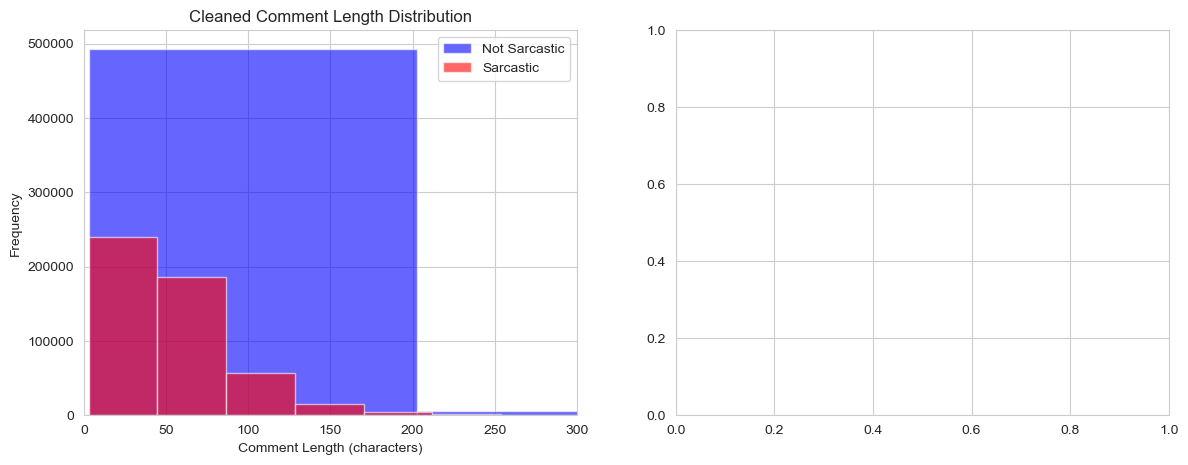

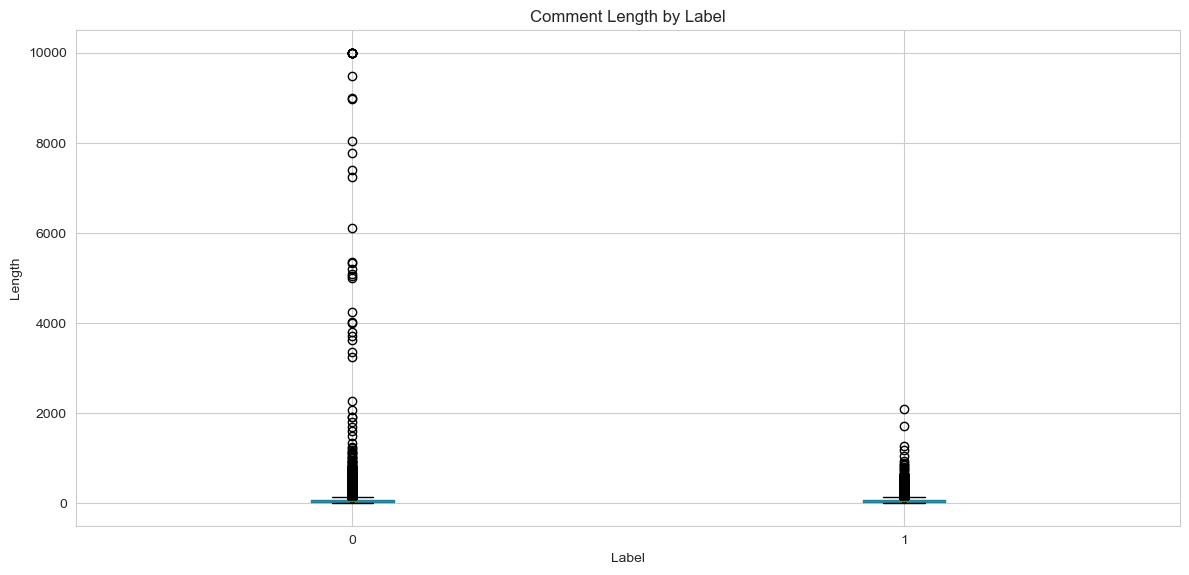


Average cleaned comment length:
Non-sarcastic: 55.3 chars
Sarcastic: 54.6 chars


In [7]:
# Check comment lengths after cleaning
df['cleaned_length'] = df['cleaned_comment'].str.len()

# Remove very short comments (less than 3 characters)
print(f"Before filtering: {len(df):,} samples")
df = df[df['cleaned_length'] >= 3]
print(f"After filtering (>= 3 chars): {len(df):,} samples")

# Remove empty comments
df = df[df['cleaned_comment'].str.strip() != '']
print(f"After removing empty: {len(df):,} samples")

# Visualize length distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df[df['label']==0]['cleaned_length'], bins=50, alpha=0.6, label='Not Sarcastic', color='blue')
plt.hist(df[df['label']==1]['cleaned_length'], bins=50, alpha=0.6, label='Sarcastic', color='red')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Frequency')
plt.title('Cleaned Comment Length Distribution')
plt.legend()
plt.xlim(0, 300)

plt.subplot(1, 2, 2)
df.boxplot(column='cleaned_length', by='label')
plt.xlabel('Label')
plt.ylabel('Length')
plt.title('Comment Length by Label')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nAverage cleaned comment length:")
print(f"Non-sarcastic: {df[df['label']==0]['cleaned_length'].mean():.1f} chars")
print(f"Sarcastic: {df[df['label']==1]['cleaned_length'].mean():.1f} chars")

In [8]:
from nltk.tokenize import word_tokenize

# Tokenize
print("Tokenizing... (may take 2-3 minutes)")
df['tokens'] = df['cleaned_comment'].apply(word_tokenize)

print("✅ Tokenization complete!")

# Show examples
print("\n" + "="*80)
print("TOKENIZATION EXAMPLES:")
print("="*80)

for i in range(3):
    print(f"\n{i+1}. Text: {df['cleaned_comment'].iloc[i]}")
    print(f"   Tokens: {df['tokens'].iloc[i][:10]}...")  # Show first 10 tokens
    print("-"*80)

Tokenizing... (may take 2-3 minutes)
✅ Tokenization complete!

TOKENIZATION EXAMPLES:

1. Text: nc and nh
   Tokens: ['nc', 'and', 'nh']...
--------------------------------------------------------------------------------

2. Text: you do know west teams play against west teams more than east teams right
   Tokens: ['you', 'do', 'know', 'west', 'teams', 'play', 'against', 'west', 'teams', 'more']...
--------------------------------------------------------------------------------

3. Text: they were underdogs earlier today but since gronk's announcement this afternoon the vegas line has moved to patriots
   Tokens: ['they', 'were', 'underdogs', 'earlier', 'today', 'but', 'since', 'gronk', "'s", 'announcement']...
--------------------------------------------------------------------------------


In [10]:
import os

# Create processed folder if it doesn't exist
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

print(f"✅ Created directory: {processed_dir}")

✅ Created directory: ../data/processed


In [11]:
# Select relevant columns
df_processed = df[['label', 'comment', 'cleaned_comment', 'tokens', 'cleaned_length']].copy()

# Save to CSV
output_path = '../data/processed/preprocessed_data.csv'
df_processed.to_csv(output_path, index=False)

print(f"✅ Preprocessed data saved to: {output_path}")
print(f"   Total samples: {len(df_processed):,}")
print(f"   Sarcastic: {df_processed['label'].sum():,}")
print(f"   Non-sarcastic: {(len(df_processed) - df_processed['label'].sum()):,}")

# Also save a smaller sample for quick testing
sample_size = 50000
df_sample = df_processed.sample(n=sample_size, random_state=42)
df_sample.to_csv('../data/processed/preprocessed_data_sample_50k.csv', index=False)

print(f"\n✅ Also saved 50k sample for quick testing")

✅ Preprocessed data saved to: ../data/processed/preprocessed_data.csv
   Total samples: 1,004,585
   Sarcastic: 504,510
   Non-sarcastic: 500,075

✅ Also saved 50k sample for quick testing


In [12]:
# Get all words from sarcastic comments
sarcastic_words = []
for tokens in df[df['label']==1]['tokens']:
    sarcastic_words.extend(tokens)

# Get all words from non-sarcastic comments
non_sarcastic_words = []
for tokens in df[df['label']==0]['tokens']:
    non_sarcastic_words.extend(tokens)

print(f"Total words in sarcastic comments: {len(sarcastic_words):,}")
print(f"Total words in non-sarcastic comments: {len(non_sarcastic_words):,}")

# Most common words
print("\n" + "="*80)
print("TOP 20 WORDS IN SARCASTIC COMMENTS:")
print("="*80)
sarcastic_counter = Counter(sarcastic_words)
for word, count in sarcastic_counter.most_common(20):
    print(f"{word:15} : {count:,}")

print("\n" + "="*80)
print("TOP 20 WORDS IN NON-SARCASTIC COMMENTS:")
print("="*80)
non_sarcastic_counter = Counter(non_sarcastic_words)
for word, count in non_sarcastic_counter.most_common(20):
    print(f"{word:15} : {count:,}")

Total words in sarcastic comments: 5,403,194
Total words in non-sarcastic comments: 5,488,895

TOP 20 WORDS IN SARCASTIC COMMENTS:
the             : 190,663
to              : 118,504
a               : 117,337
you             : 103,177
i               : 91,660
and             : 85,680
it              : 85,083
that            : 83,596
is              : 82,946
's              : 77,240
of              : 71,192
n't             : 68,646
in              : 53,060
for             : 46,877
but             : 45,433
they            : 43,509
are             : 40,668
because         : 37,328
so              : 37,154
be              : 37,046

TOP 20 WORDS IN NON-SARCASTIC COMMENTS:
the             : 206,023
i               : 143,332
a               : 128,918
to              : 120,983
it              : 97,579
you             : 94,038
and             : 88,867
that            : 84,923
is              : 82,753
of              : 78,795
in              : 63,934
's              : 63,589
n't             : 57

In [13]:
print("="*80)
print("PREPROCESSING SUMMARY")
print("="*80)

print(f"\n✅ Original dataset: 1,010,826 samples")
print(f"✅ After cleaning: {len(df_processed):,} samples")
print(f"✅ Removed: {1010826 - len(df_processed):,} samples (empty/too short)")

print(f"\n📊 Final Dataset Statistics:")
print(f"   - Sarcastic: {df_processed['label'].sum():,} ({df_processed['label'].sum()/len(df_processed)*100:.1f}%)")
print(f"   - Non-sarcastic: {len(df_processed) - df_processed['label'].sum():,} ({(1-df_processed['label'].sum()/len(df_processed))*100:.1f}%)")

print(f"\n📁 Files Created:")
print(f"   1. data/processed/preprocessed_data.csv ({len(df_processed):,} samples)")
print(f"   2. data/processed/preprocessed_data_sample_50k.csv (50,000 samples)")

print(f"\n✅ Ready for model training!")

PREPROCESSING SUMMARY

✅ Original dataset: 1,010,826 samples
✅ After cleaning: 1,004,585 samples
✅ Removed: 6,241 samples (empty/too short)

📊 Final Dataset Statistics:
   - Sarcastic: 504,510 (50.2%)
   - Non-sarcastic: 500,075 (49.8%)

📁 Files Created:
   1. data/processed/preprocessed_data.csv (1,004,585 samples)
   2. data/processed/preprocessed_data_sample_50k.csv (50,000 samples)

✅ Ready for model training!
